<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/master/tutorials/W3D2_DynamicNetworks/student/W3D2_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 3, Day 2, Tutorial 2

# Neuronal Network Dynamics: Wilson-Cowan Model


## Objectives
In the previous tutorial, you became familiar with a neuronal network consisting of only an excitatory population. Here, we extend the approach we used to include both excitatory and inhibitory neuronal populations in our network. A simple, yet powerful, model to study the dynamics of two interacting populations of excitatory and inhibitory neurons is the so-called **Wilson-Cowan** rate model, which will be the subject of this tutorial.

The objectives of this tutorial are to:

- Write the **Wilson-Cowan** equations for the firing rate dynamics of a 2D system composed of an excitatory (E) and an inhibitory (I) population of neurons
- Simulate the dynamics of the system, i.e., Wilson-Cowan model.
- Plot the frequency-current (F-I) curves for both populations (i.e., E and I).
- Visualize and inspect the behavior of the system using **phase plane analysis**, **vector fields**, and **nullclines**.

Bonus steps:

- Find and plot the **fixed points** of the Wilson-Cowan model.
- Investigate the stability of the Wilson-Cowan model by linearizing its dynamics and examining the **Jacobian matrix**.
- Learn how the Wilson-Cowan model can reach an oscillatory state.

Bonus steps (applications):
- Visualize the behavior of an Inhibition-stabilized network.
- Simulate working memory using the Wilson-Cowan model.

\\
Reference paper:

_[Wilson H and Cowan J (1972) Excitatory and inhibitory interactions in localized populations of model neurons. Biophysical Journal 12](https://doi.org/10.1016/S0006-3495(72)86068-5)_

## Setup

Please execute the cell below to initialize the notebook environment.

In [1]:
# Imports
import matplotlib.pyplot as plt    # import matplotlib
import numpy as np                 # import numpy
import scipy.optimize as opt       # import root-finding algorithm
import ipywidgets as widgets       # interactive display

In [2]:
#@title Figure Settings

%matplotlib inline

fig_w, fig_h = 8, 4.5 
my_fontsize = 16
my_params = {'axes.labelsize': my_fontsize,
          'axes.titlesize': my_fontsize,
          'figure.figsize': [fig_w, fig_h],
          'font.size': my_fontsize,
          'legend.fontsize': my_fontsize-4,
          'lines.markersize': 8.,
          'lines.linewidth': 2.,
          'xtick.labelsize': my_fontsize-2,
          'ytick.labelsize': my_fontsize-2}

plt.rcParams.update(my_params)

In [3]:
#@title Helper functions
def default_pars( **kwargs):
  pars = {}
  
  ### Excitatory parameters ###
  pars['tau_E']   = 1.   # Timescale of the E population [ms]
  pars['a_E']     = 1.2   # Gain of the E population
  pars['theta_E'] = 2.8   # Threshold of the E population

  ### Inhibitory parameters ###
  pars['tau_I']   = 2.0   # Timescale of the I population [ms]
  pars['a_I']     = 1.0   # Gain of the I population
  pars['theta_I'] = 4.0   # Threshold of the I population

  ### Connection strength ###
  pars['wEE'] = 9. # E to E
  pars['wEI'] = 4.  # I to E
  pars['wIE'] = 13. # E to I
  pars['wII'] = 11. # I to I
  
  ### External input ###
  pars['I_ext_E']  = 0.
  pars['I_ext_I']  = 0.
  
  ### simulation parameters ###
  pars['T'] = 50. # Total duration of simulation [ms]
  pars['dt'] = .1  # Simulation time step [ms]
  pars['E_init'] = 0.2 # Initial value of E
  pars['I_init'] = 0.2 # Initial value of I
  
  ### External parameters if any ###
  for k in kwargs:
      pars[k] = kwargs[k]
      
  pars['range_t'] = np.arange(0, pars['T'], pars['dt']) # Vector of discretized time points [ms]
        
  return pars

def F(x,a,theta): 
    """
    Population activation function.

    Args:
      x     : the population input
      a     : the gain of the function
      theta : the threshold of the function
    
    Returns:
      f     : the population activation response f(x) for input x
    """

    # add the expression of f = F(x)
    f = (1+np.exp(-a*(x-theta)))**-1 - (1+np.exp(a*theta))**-1

    return f

def my_test_plot(t, E1, I1, E2, I2):
  
  ax = plt.subplot(2,1,1)
  ax.plot(pars['range_t'], E1, 'b', label='E population')
  ax.plot(pars['range_t'], I1, 'r', label='I population')
  ax.set_xlabel('t (ms)')
  ax.set_ylabel('Activity')
  ax.legend(loc='best')

  ax = plt.subplot(2,1,2)
  ax.plot(pars['range_t'], E2, 'b', label='E population')
  ax.plot(pars['range_t'], I2, 'r', label='I population')
  ax.set_xlabel('t (ms)')
  ax.set_ylabel('Activity')
  ax.legend(loc='best')

  plt.tight_layout()

def my_plot_nullcline(pars):
  E_grid = np.linspace(-0.01,0.96,100)
  E_nullcline = get_E_nullcline(pars, E_grid)# calculate E nullclines
  I_grid = np.linspace(-.01,0.8,100)
  I_nullcline = get_I_nullcline(pars, I_grid)# calculate I nullclines

  plt.plot(E_grid, E_nullcline, 'b', label='E nullcline')
  plt.plot(I_nullcline, I_grid, 'r', label='I nullcline')
  plt.xlabel('E')
  plt.ylabel('I')
  plt.legend(loc='best',fontsize=12)

def my_plot_vector(pars, n_skip=2., scale=5):
  EI_grid = np.linspace(0., 1., 20)
  E_meshgrid, I_meshgrid = np.meshgrid(EI_grid,EI_grid)
  dEdt, dIdt = EIderivs(E_meshgrid, I_meshgrid, pars)

  n_skip = 2
  plt.quiver(E_meshgrid[::n_skip,::n_skip], I_meshgrid[::n_skip,::n_skip], 
            dEdt[::n_skip,::n_skip], dIdt[::n_skip,::n_skip], 
            angles='xy', scale_units='xy', scale=5,facecolor='c')
  
  plt.xlabel('E')
  plt.ylabel('I')

def my_plot_trajectory(pars, mycolor, x_init, mylabel):
  pars['E_init'], pars['I_init'] = x_init[0], x_init[1]
  E_tj, I_tj= simulate_wc(pars)
  plt.plot(E_tj, I_tj, color=mycolor, label=mylabel)
  plt.plot(x_init[0], x_init[1], 'o', color=mycolor, ms=8)

  plt.xlabel('E')
  plt.ylabel('I')

def my_plot_trajectories(pars, dx, n, mylabel):
  """
  Solve for I along the E_grid from dE/dt = 0.
  
  Expects:
  pars    : Parameter dictionary
  dx      : increment of initial values
  n       : n*n trjectories
  mylabel : label for legend
  
  Returns:
    figure of trajectory
  """

  for ie in range(n):          
    for ii in range(n):
      pars['E_init'], pars['I_init'] = dx*ie, dx*ii
      E_tj, I_tj= simulate_wc(pars)
      if (ie==n-1)&(ii==n-1):
          plt.plot(E_tj, I_tj, 'k', alpha=0.3, label=mylabel)
      else:
          plt.plot(E_tj, I_tj, 'k', alpha=0.3)

  plt.xlabel('E')
  plt.ylabel('I')

def check_fp(x_fp):

  dEdt, dIdt = EIderivs(x_fp[0], x_fp[1], pars)

  return dEdt**2 + dIdt**2<1e-6

def plot_fp(x_fp, mycolor):
  plt.plot(x_fp_2[0], x_fp_2[1], 'o', color=mycolor, ms=8)


def dF(x,a,theta): 
  """
  Population activation function.

  Args:
    x     : the population input
    a     : the gain of the function
    theta : the threshold of the function
  
  Returns:
    the population activation response F(x) for input x
  """

  dFdx = a*np.exp(-a*(x-theta))*(1+np.exp(-a*(x-theta)))**-2

  return dFdx

# Wilson-Cowan model of excitatory and inhibitory populations


Video available at https://youtube.com/watch?v=EgEad5Me_Ro


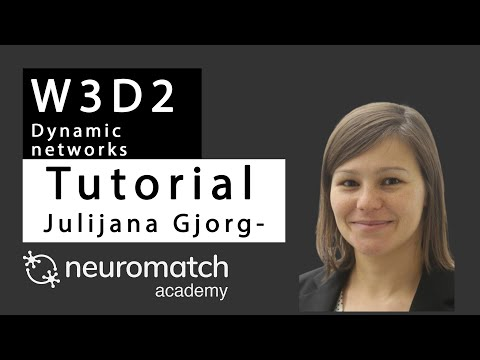

In [4]:
#@title Video: Phase analysis of the Wilson-Cowan E-I model
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="EgEad5Me_Ro", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

Many of the rich dynamics recorded in the brain are generated by the interaction of excitatory and inhibitory subtype neurons. Here, similar to what we did in the previous tutorial, we will model two coupled populations of E and I neurons (**Wilson-Cowan** model). We can, in fact, write two rate-based equations, one for each population, with interacting terms:

\begin{align}
\tau_E \frac{dE}{dt} &= -E + F_E(w_{EE}E -w_{EI}I + I^{\text{ext}}_E;a_E,\theta_E)\\
\tau_I \frac{dI}{dt} &= -I + F_I(w_{IE}E -w_{II}I + I^{\text{ext}}_I;a_I,\theta_I)    \qquad (1)
\end{align}

$E(t)$ represents the average activation (or firing rate) of the excitatory population at time $t$, and $I(t)$ the activation (or firing rate) of the inhibitory population. The parameters $\tau_E$ and $\tau_I$ control the timescales of the dynamics of each population. Connection strengths are given by: $w_{EE}$ (E $\rightarrow$ E), $w_{EI}$ (I $\rightarrow$ E), $w_{IE}$ (E $\rightarrow$ I), and $w_{II}$ (I $\rightarrow$ I). The terms $w_{EI}$ and $w_{IE}$ are the interacting terms and, respectively, represent connections from inhibitory to excitatory population and vice versa. The transfer functions (or F-I curves) $F_E(x;a_E,\theta_E)$ and $F_I(x;a_I,\theta_I)$ can be different for the excitatory and the inhibitory populations.

\\

Now execute the cell below to initialize simulation parameters and define the handler functions we will use throughout the tutorial.

## Exercise 1: plot out the f-I curves for the E and I populations 

Let's first plot out the f-I curves for the E and I populations by the function the defined above with the default values

In [5]:
# Exercise 1
pars = default_pars() # get the default value
x = np.arange(0,10,.1) # set the input

print(pars['a_E'], pars['theta_E'])
print(pars['a_I'], pars['theta_I'])
###################################################################
## TODO for students: compute and plot the F-I curve here         #
## Note: aE, thetaE, aI and theta_I are in the dictionray 'pars'  #
###################################################################

1.2 2.8
1.0 4.0


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D2_DynamicNetworks/solutions/W3D2_Tutorial2_Solution_187031a9.py)

*Example output:*

<img alt='Solution hint' align='left' width=513 height=357 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D2_DynamicNetworks/static/W3D2_Tutorial2_Solution_187031a9_3.png>



## Simulation scheme for the Wilson-Cowan model

Using the Euler method, the E-I dynamical system can be simulated on a time-grid of stepsize $\Delta t$. The updates for the activity of the excitatory and the inhibitory populations can be written as:

\begin{align}
E[k+1] &= E[k] + \frac{\Delta t}{\tau_E}[-E[k] + F_E(w_{EE}E[k] -w_{EI}I[k] + I^{\text{ext}}_E[k];a_E,\theta_E)]\\
I[k+1] &= I[k] + \frac{\Delta t}{\tau_I}[-I[k] + F_I(w_{IE}E[k] -w_{II}I[k] + I^{\text{ext}}_I[k];a_I,\theta_I)] 
\end{align}

### Exercise 2: Numerically integrate the Wilson-Cowan equations

In [7]:
# Exercise 2

def simulate_wc(pars):   
  """
  Simulate the Wilson-Cowan equations 
  
  Args:
    pars : Parameter dictionary
  
  Returns:
    E    : Activity of excitatory population (array)
    I    : Activity of inhibitory population (array)
  """
  
  # Set parameters
  tau_E, a_E, theta_E = pars['tau_E'], pars['a_E'], pars['theta_E']
  tau_I, a_I, theta_I = pars['tau_I'], pars['a_I'], pars['theta_I']
  wEE, wEI = pars['wEE'], pars['wEI'] 
  wIE, wII = pars['wIE'], pars['wII']
  I_ext_E, I_ext_I = pars['I_ext_E'], pars['I_ext_I'] 
  E_init, I_init = pars['E_init'], pars['I_init']       
  dt, range_t = pars['dt'], pars['range_t'] 
  Lt = range_t.size 
      
  # Initialize activity
  E = np.zeros(Lt)
  I = np.zeros(Lt)
  E[0] = E_init
  I[0] = I_init
  I_ext_E = I_ext_E * np.ones(Lt)
  I_ext_I = I_ext_I * np.ones(Lt)  #ensure the external input an array

  # simulate the Wilson-Cowan equations 
  for k in range(Lt-1):
    ######################################################################
    ## TODO for students: compute dE and dI, remove  NotImplementedError #
    ######################################################################
    # dE = ...
    # dI = ...
    raise NotImplementedError("Student excercise: compute the change in E/I")
    
    E[k+1] = E[k] + dE
    I[k+1] = I[k] + dI
    
  return E, I


# Uncomment the below lines after completing the simulate_wc function
# Here are tow trjectories with close intial values

#pars = default_pars()
#pars['E_init'], pars['I_init'] = 0.32, 0.15
#E1,I1 = simulate_wc(pars)
#pars['E_init'], pars['I_init'] = 0.33, 0.15
#E2,I2 = simulate_wc(pars)

#my_test_plot(pars['range_t'], E1, I1, E2, I2)


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D2_DynamicNetworks/solutions/W3D2_Tutorial2_Solution_88ca5a4b.py)

*Example output:*

<img alt='Solution hint' align='left' width=560 height=380 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D2_DynamicNetworks/static/W3D2_Tutorial2_Solution_88ca5a4b_0.png>



### Interactive Demo: population trajectories with different intial values
In this interactive demo we will simulate the Wilson-Cowan model and plot the trajectories of each population for different initial conditions.


**Remember to enable the demo by running the cell.**

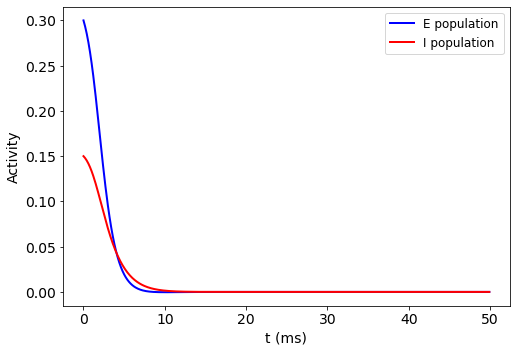

In [9]:
#@title System trajectories with different initial conditions
def plot_EI_diffinitial(E_init = 0.0):

  pars = default_pars()
  pars['E_init'], pars['I_init'] = E_init, 0.15
  E, I = simulate_wc(pars)
  
  plt.figure(figsize=(8, 5.5))
  plt.plot(pars['range_t'], E, 'b', label='E population')
  plt.plot(pars['range_t'], I, 'r', label='I population')
  plt.xlabel('t (ms)', fontsize=14)
  plt.ylabel('Activity', fontsize=14)
  plt.legend(loc='best', fontsize=12)
  plt.show()

_ = widgets.interact(plot_EI_diffinitial, E_init = (0.30, 0.35, .01))   

Question: It is evident that the steady states of the neuronal response can be different when the initial states are chosen to be different. Why is that? If this phenomenon confuses you, we will give the answer right below.

## Phase plane analysis

We will next introduce the phase plane analysis to understand the behavior of the E and I populations in the Wilson-Cowan model. So far, we have plotted the activities of the two populations as a function of time, i.e. in the `Activity-t` plane, either the $(t, E(t))$ plane or the and $(t, I(t))$ one. Instead, we can plot the two activities $E(t)$ and $I(t)$ against each other at any time point $t$. This characterization in the `I-E` plane $(I(t), E(t))$ is called the **phase plane**. Each line in the phase plane indicates how both $E$ and $I$ evolve with time.

### Interactive Demo: From the `Activity-t` plane to the `I-E` phase plane

In this demo widget, we will visualize the system dynamics using both the `Activity-time` and the `(E, I)` phase plane. The circles indicate the activities at a given time $t$, while the lines represent the evolution of the system for the entire duration of the simulation.

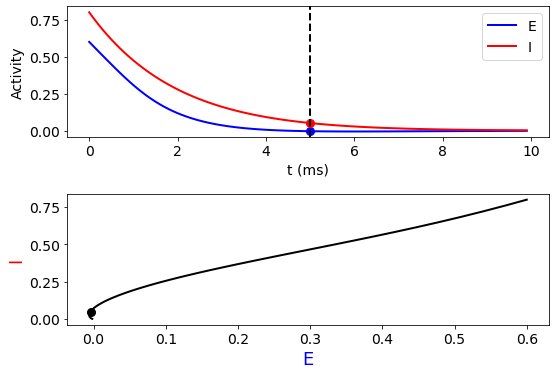

In [10]:
#@title `Activity-t` plane vs `I-E` phase plane 

pars = default_pars(T=10)
pars['E_init'], pars['I_init'] = 0.6, 0.8
E,I = simulate_wc(pars)

def plot_activity_phase(n_t):
  plt.figure(figsize=(8, 5.5))
  plt.subplot(2,1,1)
  plt.plot(pars['range_t'], E, 'b', label='E')
  plt.plot(pars['range_t'], I, 'r', label='I')
  plt.plot(pars['range_t'][n_t], E[n_t], 'bo')
  plt.plot(pars['range_t'][n_t], I[n_t], 'ro')
  plt.axvline(pars['range_t'][n_t], 0, 1, color='k', ls='--')
  plt.xlabel('t (ms)', fontsize=14)
  plt.ylabel('Activity', fontsize=14)
  plt.legend(loc='best', fontsize=14)

  plt.subplot(2,1,2)
  plt.plot(E, I, 'k')
  plt.plot(E[n_t], I[n_t], 'ko')
  plt.xlabel('E', fontsize=18, color='b')
  plt.ylabel('I', fontsize=18, color='r')

  plt.tight_layout()
  plt.show()

_ = widgets.interact(plot_activity_phase, n_t = (0, len(pars['range_t']-1), 1))  

Video available at https://youtube.com/watch?v=BnwMK9dxCnk


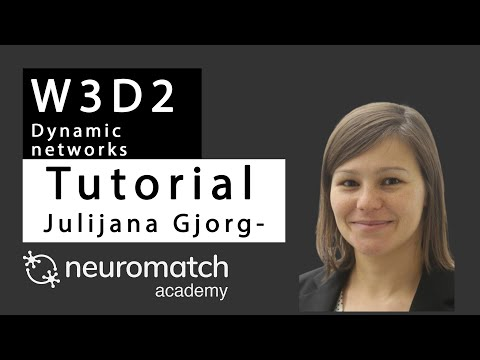

In [11]:
#@title Video: Nullclines and Vector Fields
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="BnwMK9dxCnk", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

### Nullclines of the Wilson-Cowan Equations

An important concept in the phase plane analysis is the "nullcline", which is defined as the set of points in the phase plane where the activity of one population (but not necessarily the other) does not change.

In other words, the $E$ and $I$ nullclines of Equation $(1)$ are defined as the points where $\displaystyle{\frac{dE}{dt}}=0$, for the excitatory nullcline, or $\displaystyle\frac{dI}{dt}=0$ for the inhibitory nullcline. That is:

\begin{align}
-E + F_E(w_{EE}E -w_{EI}I + I^{\text{ext}}_E;a_E,\theta_E) &= 0  \qquad (2)\\[1mm]
-I + F_I(w_{IE}E -w_{II}I + I^{\text{ext}}_I;a_I,\theta_I) &= 0    \qquad (3)
\end{align}

Formally, Equations $2$ and $3$ can be written in the following form:

\begin{align}
I = \frac{1}{w_{EI}}\big{[}w_{EE}E - F_E^{-1}(E; a_E,\theta_E) + I^{\text{ext}}_E \big{]} \qquad (4)
\end{align}

Where $F_E^{-1}(E; a_E,\theta_E)$ is the inverse of the excitatory transfer function. Equation $4$ defines the $E$ nullcline.


Similarly, the $I$ nullcline is found as:
\begin{align}
E = \frac{1}{w_{IE}} \big{[} w_{II}I + F_I^{-1}(I;a_I,\theta_I) - I^{\text{ext}}_I \big{]}.  \qquad (5)  
\end{align}

Where $F_I^{-1}(x; a_I,\theta_I)$ is the inverse of the inhibitory transfer function. Equation $5$ defines the $I$ nullcline.

\\

#### Exercise 3: Compute the nullclines of the Wilson-Cowan model

In the next exercise, we will compute and plot the $E$ and the $I$ nullclines using Equations $4$ - $5$.
Note that, when computing the nullclines with Equations $4$-$5$, we also need to calculate the inverse of the transfer functions.

In [12]:
# Exercise 3: Nullclines of Wilson-Cowan model

# Define the inverse of F
def F_inv(x,a,theta): 
  """
  Args:
    x         : the population input
    a         : the gain of the function
    theta     : the threshold of the function
  
  Returns:
    F_inverse : value of the inverse function
  """
  
  #####################################################################
  ## TODO for students: compute F_inverse, remove NotImplementedError #
  #####################################################################
  # F_inverse = ...
  raise NotImplementedError("Student excercise: compute the inverse of F(x)")

  return F_inverse


# get the nullcline for E, solve Equation. (4) along the E-grid
def get_E_nullcline(pars, E_grid):
  """
  Solve for I along the E_grid from dE/dt = 0.
  
  Args:
    pars   : Parameter dictionary
    E_grid : a single value or an array
  
  Returns:
    I      : values of inhibitory population along the nullcline on the E-grid
  """
  
  a_E, theta_E = pars['a_E'], pars['theta_E']
  wEE, wEI = pars['wEE'], pars['wEI'] 
  I_ext_E = pars['I_ext_E']

  ###########################################
  ## TODO for students: compute E nullcline #
  ###########################################
  # I = ...
  raise NotImplementedError("Student excercise: compute the E nullcline")
  
  return I

# get the nullcline for I, solve Equation. (5) along the I-grid
def get_I_nullcline(pars, I_grid):
  """
  Solve for E along the I_grid from dI/dt = 0.
  
  Args:
    pars   : Parameter dictionary
    I_grid : a single value or an array
  
  Returns:
    E      : values of the excitatory population along the nullcline on the I-grid
  """
  
  a_I, theta_I = pars['a_I'], pars['theta_I']
  wIE, wII = pars['wIE'], pars['wII']
  I_ext_I =  pars['I_ext_I'] 

  ###########################################
  ## TODO for students: compute I nullcline #
  ###########################################
  # E = ...
  raise NotImplementedError("Student excercise: compute the I nullcline")
  
  return E 

# Uncomment the below lines after completing the all above functions
# pars = default_pars() # get parameters
# my_plot_nullcline(pars)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D2_DynamicNetworks/solutions/W3D2_Tutorial2_Solution_a1723906.py)

*Example output:*

<img alt='Solution hint' align='left' width=513 height=357 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D2_DynamicNetworks/static/W3D2_Tutorial2_Solution_a1723906_0.png>



### Vector field

How can the phase plane and the nullcline curves help us understand the behavior of the Wilson-Cowan model? 

The activities of the $E$ and $I$ populations $E(t)$ and $I(t)$ at each time point $t$ correspond to a single point in the phase plane, with coordinates $(E(t),I(t))$. Therefore, the time-dependent trajectory of the system can be described as a continuous curve in the phase plane, and the tangent vector to the trajectory, which is defined as the vector $\bigg{(}\displaystyle{\frac{dE(t)}{dt},\frac{dI(t)}{dt}}\bigg{)}$, indicates the direction towards which the activity is evolving and how fast is the activity changing along each axis. In fact, for each point $(E,I)$ in the phase plane, we can compute the tangent vector $\bigg{(}\displaystyle{\frac{dE}{dt},\frac{dI}{dt}}\bigg{)}$, which will indicate the behavior of the system when it traverses that point. The map of tangent vectors in the phase plane is called **vector field**. The behavior of any trajectory in the phase plane is determined by i) the initial conditions $(E(0),I(0))$, and ii) the vector field $(\displaystyle{\frac{dE(t)}{dt},\frac{dI(t)}{dt}})$.

In general, the value of the vector field at a particular point in the phase plane is represented by an arrow. The orientation and the size of the arrow reflect the direction and the norm of the vector, respectively.

#### Exercise 4: Compute and plot the vector field $\displaystyle{\Big{(}\frac{dE}{dt}, \frac{dI}{dt} \Big{)}}$

In [14]:
# Exercise 4
# Define the value of the derivatives according to Equation. (1)
def EIderivs(E_grid, I_grid, pars):
  """
  Time derivatives for E/I variables (dE/dt, dI/dt).
  """
  
  tau_E, a_E, theta_E = pars['tau_E'], pars['a_E'], pars['theta_E']
  tau_I, a_I, theta_I = pars['tau_I'], pars['a_I'], pars['theta_I']
  wEE, wEI = pars['wEE'], pars['wEI'] 
  wIE, wII = pars['wIE'], pars['wII']
  I_ext_E, I_ext_I = pars['I_ext_E'], pars['I_ext_I'] 
  
  ##########################################################################
  ## TODO for students: compute dEdt and dI/dt, remove NotImplementedError #
  ##########################################################################
  # dEdt = ...
  # dIdt = ...
  raise NotImplementedError("Student excercise: compute the vector field")
  
  return dEdt, dIdt

# Uncomment these lines after completing the EIderivs function
# pars = default_pars()
# my_plot_trajectories(pars, 0.2, 6, 'Sample trajectories \nof different initials')
# my_plot_trajectory(pars, 'orange', [0.6, 0.8], 'Sample trajectory to \nlow activity')
# my_plot_trajectory(pars, 'm', [0.6, 0.6], 'Sample trajectory to \nhigh activity')
# my_plot_vector(pars)
# my_plot_nullcline(pars)
# plt.legend(loc=[1.02, 0.6], fontsize=12, handlelength=1)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D2_DynamicNetworks/solutions/W3D2_Tutorial2_Solution_a20da002.py)

*Example output:*

<img alt='Solution hint' align='left' width=617 height=387 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D2_DynamicNetworks/static/W3D2_Tutorial2_Solution_a20da002_0.png>



### Think! 

The last phase plane plot showed us that: 
- trajectories seem to follow the direction of the vector field
- different trajectories eventually always reach one of two points depending on the initial conditions. Note that the two points are the intersection of the two nullcline curves. 

There are, in total, three intersection points, but one of them is never the final state of a trajectory. Why is that? 

## Summary

Congratulations! You have finished the second day of the last week of neuromatch academy! Here, you learned how to simulate a rate based model consisting of excitatory and inhibitory population of neurons.

In the last tutorial on dynamical neuronal networks you learned to:
- Implement and simulate a 2D system composed of an E and an I population of neurons using the **Wilson-Cowan** model
- Plot the frequency-current (F-I) curves for both populations
- Examine the behavior of the system using phase **plane analysis**, **vector fields**, and **nullclines**.

Do you have more time? Have you finished early? We have more fun material for you!

Below are some, more advanced concepts on dynamical systems:

- You will learn how to find the fixed points on such a system, and to investigate its stability by linearizing its dynamics and examining the **Jacobian matrix**.
- You will see how the Wilson-Cowan model can reach an oscillatory state.

If you need even more, there are two applications of the Wilson-Cowan model:

- Visualization of an Inhibition-stabilized network
- Simulation of working memory

## Bonus 1: Fixed points, stability analysis, and limit cycles in the Wilson-Cowan model

Video available at https://youtube.com/watch?v=RgysOunhhwM


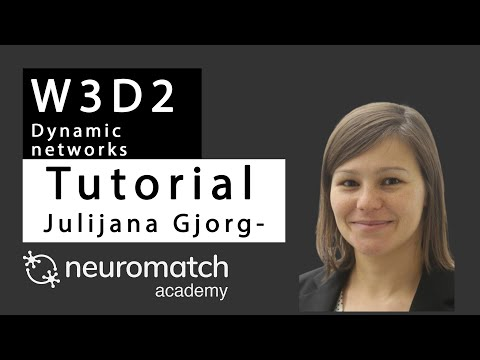

In [16]:
#@title Video: Fixed points and their stability
from IPython.display import YouTubeVideo
video = YouTubeVideo(id="RgysOunhhwM", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

### Fixed Point of the E/I system

Clearly, the intersection points of the two nullcline curves are the fixed points of the Wilson-Cowan model in Equation $(1)$. 

In the next exercise, we will find the coordinate of all fixed points for a given set of parameters.

Let's start by inspecting and then executing the cell below.

In [17]:
def my_fp(pars, E_init, I_init):
  """
  use opt.root function to solve Equations. (4)-(5) from an initial [E_init, I_init]
  """
  
  tau_E, a_E, theta_E = pars['tau_E'], pars['a_E'], pars['theta_E']
  tau_I, a_I, theta_I = pars['tau_I'], pars['a_I'], pars['theta_I']
  wEE, wEI = pars['wEE'], pars['wEI'] 
  wIE, wII = pars['wIE'], pars['wII']
  I_ext_E, I_ext_I = pars['I_ext_E'], pars['I_ext_I'] 
  
  # define the right hand of wilson-cowan equations
  def my_WCr(x):
      
    E = x[0]
    I = x[1]
    
    dEdt=(-E + F(wEE*E-wEI*I+I_ext_E,a_E,theta_E))/tau_E
    dIdt=(-I + F(wIE*E-wII*I+I_ext_I,a_I,theta_I))/tau_I
    y = np.array([dEdt, dIdt])
    
    return y
  
  x0 = np.array([E_init, I_init])
  x_fp = opt.root(my_WCr, x0).x
  
  return x_fp

#### Exercise 5: Find the fixed points of the Wilson-Cowan model

From the above nullclines, we notice that the system features  three fixed points with the parameters we used. To find their coordinates, we need to choose the proper initial value to give to the `opt.root` function inside of the function `my_fp` we just defined, since the algorithm can only find fixed points in the vicinity of the initial value. 

In this exercise, you will use the function `my_fp` to find each of the fixed points by varying the initial values.

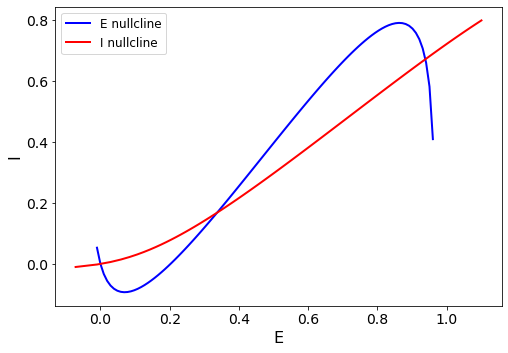

In [18]:
# Exercise 5
pars = default_pars()

plt.figure(figsize=(8, 5.5))
my_plot_nullcline(pars)

#####################################################
## TODO for students:                               #
# Calculate the fixed point with your initial value #
# verify your fixed point and plot the corret ones  #
#####################################################


#x_fp = my_fp(pars, )
#check if x_fp is the intersection of the lines with the give function check_fp(x_fp)
#vary different initial values to find the correct fixed point
#if check_fp(x_fp):
#  plot_fp(x_fp)  #you can plot fixedpoit directly by plt.plot(...)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D2_DynamicNetworks/solutions/W3D2_Tutorial2_Solution_954c437d.py)

*Example output:*

<img alt='Solution hint' align='left' width=513 height=357 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D2_DynamicNetworks/static/W3D2_Tutorial2_Solution_954c437d_0.png>



### Stability of a fixed point and eigenvalues of the Jacobian Matrix

First, let's first rewrite the system $1$ as:

\begin{align}
&\frac{dE}{dt} = G_E(E,I)\\[0.5mm]
&\frac{dI}{dt} = G_I(E,I) \qquad (11)
\end{align}
where

\begin{align}
&G_E(E,I) = \frac{1}{\tau_E} [-E + F_E(w_{EE}E -w_{EI}I + I^{\text{ext}}_E;a,\theta)]\\[1mm]
&G_I(E,I) = \frac{1}{\tau_I} [-I + F_I(w_{IE}E -w_{II}I + I^{\text{ext}}_I;a,\theta)]
\end{align}

By definition, $\displaystyle\frac{dE}{dt}=0$ and $\displaystyle\frac{dI}{dt}=0$ at each fixed point. Therefore, if the initial state is exactly at the fixed point, the state of the system will not change as time evolves. However, if the initial state deviates slightly from the fixed point, two possibilities will happen (1) the trajectory will be attracted back to the fixed point (2) the trajectory will diverge from the fixed point. These two possibilities define the type of fixed point, i.e., stable or unstable. Similar to the 1d system studied in the previous tutorial, the stability of a fixed point $(E, I)$ can be determined by linearizing the dynamics of the system (can you figure out how?). The linearization will yield a matrix of first-order derivatives called the Jacobian matrix:

 \begin{equation}
   J=
  \left[ {\begin{array}{cc}
   \displaystyle{\frac{\partial G_E}{\partial E}} & \displaystyle{\frac{\partial G_E}{\partial I}}\\[1mm]
   \displaystyle\frac{\partial G_I}{\partial E} & \displaystyle\frac{\partial G_I}{\partial I} \\
  \end{array} } \right]. \quad (12)
\end{equation}

 The eigenvalues of the Jacobian matrix calculated at the fixed point will determine whether it is a stable or unstable fixed point.

\\

We can now compute the derivatives needed to build the Jacobian matrix. Using the chain and product rules, the derivatives for the excitatory population are given by:
\begin{align}
&\frac{\partial G_E}{\partial E} = \frac{1}{\tau_E} [-1 + w_{EE} F_E'(w_{EE}E -w_{EI}I +  I^{\text{ext}}_E)] \\[1mm]
&\frac{\partial G_E}{\partial I} = \frac{1}{\tau_E} [-w_{EI} F_I'(w_{EE}E -w_{EI}I +  I^{\text{ext}}_E)] 
\end{align}

The same applies to the inhibitory population. 

#### Exercise 6: Compute the Jacobian Matrix for the Wilson-Cowan model

In [20]:
# Exercise 6
def get_eig_Jacobian(pars, fp):
  """
  Simulate the Wilson-Cowan equations 
  
  Args:
    pars  : Parameter dictionary
    fp    : fixed point (E, I), array
  
  Returns:
    evals : 2x1 vector of eigenvalues of the Jacobian matrix
  """
  
  #get the parameters
  tau_E, a_E, theta_E = pars['tau_E'], pars['a_E'], pars['theta_E']
  tau_I, a_I, theta_I = pars['tau_I'], pars['a_I'], pars['theta_I']
  wEE, wEI = pars['wEE'], pars['wEI'] 
  wIE, wII = pars['wIE'], pars['wII']
  I_ext_E, I_ext_I = pars['I_ext_E'], pars['I_ext_I']

  #initialization
  E = fp[0]
  I = fp[1]
  J = np.zeros((2,2))
  
  ######################################################################
  ## TODO for students: compute J, then remove the NotImplementedError #
  ######################################################################
  # J[i, j] = ...
  raise NotImplementedError("Student excercise: compute the Jacobian matrix")    
  
  # Eigenvalues
  evals = np.linalg.eig(J)[0]
  
  return evals

# Uncomment these lines after completing the get_eig_Jacobian function
# only when you get the correct fixed point above you print their eigenvalues below  

#eig_1 = get_eig_Jacobian(pars, x_fp_1)
#eig_2 = get_eig_Jacobian(pars, x_fp_2)
#eig_3 = get_eig_Jacobian(pars, x_fp_3)
#print(eig_1, 'Stable point')
#print(eig_2, 'Unstable point')
#print(eig_3, 'Stable point')

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D2_DynamicNetworks/solutions/W3D2_Tutorial2_Solution_0349af2c.py)



As is evident, the stable point corresponds to the negative eigenvalues, while unstable point corresponds to at least one positive eigenvalue.

Below we investigate the effect of $w_{EE}$ on the nullclines and the eigenvalues of the dynamical system. <font color='black'> _Critical change is referred as **pitchfork bifurcation**._</font> 

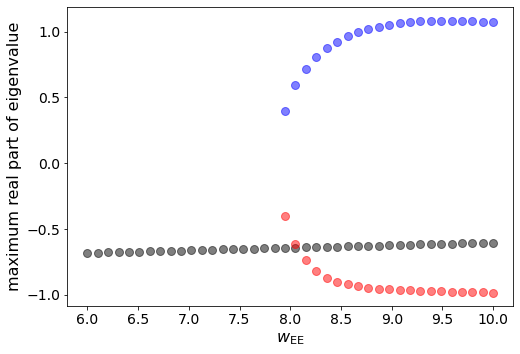

In [22]:
#@title Effect of `wEE` on the nullclines and the eigenvalues
eig_1_M = []
eig_2_M = []
eig_3_M = []
pars = default_pars()
wEE_grid = np.linspace(6,10,40)
my_thre = 7.9
for wEE in wEE_grid:
    x_fp_1 = [0., 0.]
    x_fp_2 = [.4, .1]
    x_fp_3 = [.8, .1]
    pars['wEE'] = wEE
    if wEE < my_thre:
        x_fp_1 = my_fp(pars, x_fp_1[0], x_fp_1[1])
        eig_1 = get_eig_Jacobian(pars, x_fp_1)
        eig_1_M.append(np.max(np.real(eig_1)))
    else:
        x_fp_1 = my_fp(pars, x_fp_1[0], x_fp_1[1])
        eig_1 = get_eig_Jacobian(pars, x_fp_1)
        eig_1_M.append(np.max(np.real(eig_1)))

        x_fp_2 = my_fp(pars, x_fp_2[0], x_fp_2[1])
        eig_2 = get_eig_Jacobian(pars, x_fp_2)
        eig_2_M.append(np.max(np.real(eig_2)))
        
        x_fp_3 = my_fp(pars, x_fp_3[0], x_fp_3[1])
        eig_3 = get_eig_Jacobian(pars, x_fp_3)
        eig_3_M.append(np.max(np.real(eig_3)))

eig_1_M = np.array(eig_1_M)
eig_2_M = np.array(eig_2_M)
eig_3_M = np.array(eig_3_M)

plt.figure(figsize=(8, 5.5))
plt.plot(wEE_grid, eig_1_M, 'ko', alpha=0.5)
plt.plot(wEE_grid[wEE_grid>=my_thre], eig_2_M, 'bo', alpha=0.5)
plt.plot(wEE_grid[wEE_grid>=my_thre], eig_3_M, 'ro', alpha=0.5)
plt.xlabel(r'$w_{\mathrm{EE}}$')
plt.ylabel('maximum real part of eigenvalue')
plt.show()

#### Interactive Demo: Nullclines position in the phase plane changes with parameter values.

In this interactive widget, we will explore how the nullclines move for different values of the parameter $w_{EE}$.

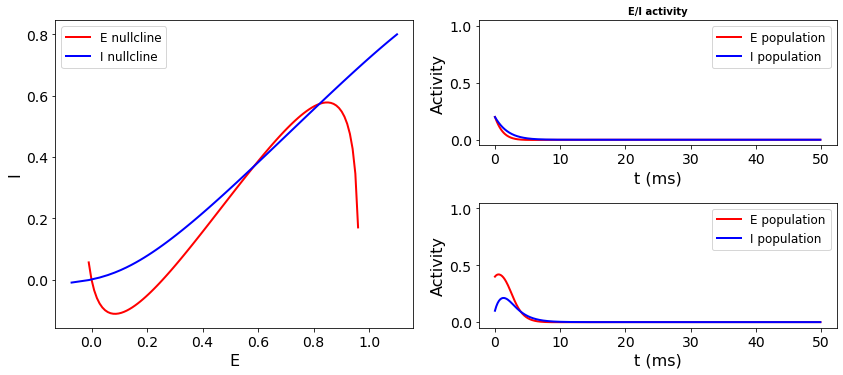

In [23]:
#@title Nullcline Explorer
def plot_nullcline_diffwEE(wEE):
  '''
    plot nullclines for different values of wEE
  '''
  pars = default_pars()
  pars['wEE'] = wEE

  # plot the E, I nullclines
  E_grid = np.linspace(-0.01,.96,100)
  E_nullcline = get_E_nullcline(pars, E_grid)

  I_grid = np.linspace(-.01,.8,100)
  I_nullcline = get_I_nullcline(pars, I_grid)

  plt.figure(figsize=(12, 5.5))
  plt.subplot(1, 2, 1)
  plt.plot(E_grid, E_nullcline, 'r', label='E nullcline')
  plt.plot(I_nullcline, I_grid, 'b', label='I nullcline')
  #plt.xlim(0.6, 1.0)
  #plt.ylim(0.3, 0.6)
  plt.xlabel('E')
  plt.ylabel('I')
  plt.legend(loc='best')

  plt.subplot(2, 2, 2)
  pars['E_init'], pars['I_init'] = 0.2, 0.2
  E, I = simulate_wc(pars)
  plt.plot(pars['range_t'], E, 'r', label='E population', clip_on=False)
  plt.plot(pars['range_t'], I, 'b', label='I population', clip_on=False)
  plt.xlabel('t (ms)')
  plt.ylabel('Activity')
  plt.legend(loc='best')
  plt.ylim(-0.05, 1.05)
  plt.title('E/I activity', fontsize=10, fontweight='bold')

  plt.subplot(2, 2, 4)
  pars['E_init'], pars['I_init'] = 0.4, 0.1
  E, I = simulate_wc(pars)
  plt.plot(pars['range_t'], E, 'r', label='E population', clip_on=False)
  plt.plot(pars['range_t'], I, 'b', label='I population', clip_on=False)
  plt.xlabel('t (ms)')
  plt.ylabel('Activity')
  plt.legend(loc='best')
  plt.ylim(-0.05, 1.05)

  plt.tight_layout()
  plt.show()

_ = widgets.interact(plot_nullcline_diffwEE, wEE = (6., 10., .01))

##### Task: effect of other parameters
We can also investigate the effect of different $w_{EI}$, $w_{IE}$, $w_{II}$, $\tau_{E}$, $\tau_{I}$, and $I_{E}^{\text{ext}}$ on the stability of fixed points. In addition, we can also consider the perturbation on the parameters of the gain curve $F(\cdot)$

## Limit cycle

If we use a different set of parameters, $w_{EE}=6.4$, $w_{EI}=4.8$, $w_{IE}=6.$, $w_{II}=1.2$, and $I_{E}^{\text{ext}}=0.8$, then we shall observe that the E and I population activity start to oscillate! Please execute the cell below to check the oscillatory behavior. 

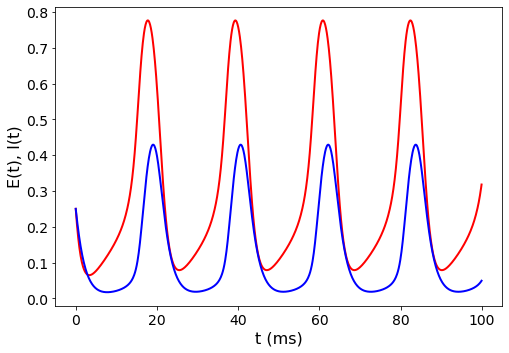

In [24]:
#@title Oscillations
pars = default_pars(T=100.)
pars['wEE'], pars['wEI'] = 6.4, 4.8
pars['wIE'], pars['wII'] = 6.0, 1.2
pars['I_ext_E'] = 0.8
pars['E_init'], pars['I_init'] = 0.25, 0.25

E,I = simulate_wc(pars)
plt.figure(figsize=(8, 5.5))
plt.plot(pars['range_t'], E, 'r')
plt.plot(pars['range_t'], I, 'b')
plt.xlabel('t (ms)')
plt.ylabel('E(t), I(t)')
plt.show()

##### Exercise 7: Plot the phase plane

We can also understand the oscillations of the population behavior using the phase plane. By plotting a set of trajectories with different initial states, we can see that these trajectories will move in a circle instead of converging to a fixed point. This circle is called "limit cycle", and shows the periodic oscillations of the $E$ and $I$ population behavior under some conditions.

Try to plot the phase plane using the previously defined functions.

In [25]:
pars = default_pars(T=100.)
pars['wEE'], pars['wEI'] = 6.4, 4.8
pars['wIE'], pars['wII'] = 6.0, 1.2
pars['I_ext_E'] = 0.8

###############################################################################
## TODO for students: plot phase plane: nullclines, trajectories, fixed point #
###############################################################################

## please make sure you find the corret fixed point

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D2_DynamicNetworks/solutions/W3D2_Tutorial2_Solution_fedbbbea.py)

*Example output:*

<img alt='Solution hint' align='left' width=513 height=357 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/tutorials/W3D2_DynamicNetworks/static/W3D2_Tutorial2_Solution_fedbbbea_1.png>



#### Interactive Demo: Limit cycle and oscillations.

From the above examples, the change of model parameters changes the shape of the nullclines and accordingly, the behavior of the $E$ and $I$ populations from steady fixed points to oscillations. However, the shape of the nullclines is unable to fully determine the behavior of the network. The vector field also matters. To demonstrate this, here we will investigate the effect of time constants on the population behavior. By changing the inhibitory time constant $\tau_I$, the nullclines do not change, but the network behavior changes substantially from steady state to oscillations with different frequencies. 

Such a dramatic change in the system behavior is referred to as a **bifurcation**. 

\\
Please execute the code below to check this out.

tau_I=0.5 ms, eigenvalue of J matrix  [-0.82789338+0.78902255j -0.82789338-0.78902255j]


findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


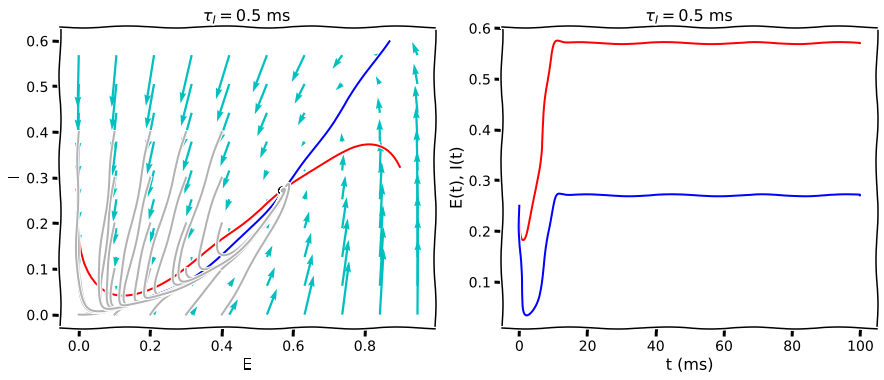

In [27]:
#@title Limit Cycle Explorer

def time_constant_effect(tau_s=0.5):
    
  pars = default_pars(T=100.)
  pars['wEE'], pars['wEI'] = 6.4, 4.8
  pars['wIE'], pars['wII'] = 6.0, 1.2
  pars['I_ext_E'] = 0.8

  pars['tau_I'] = tau_s 
  
  E_grid = np.linspace(0.0,.9,100)
  I_grid = np.linspace(0.0,.6,100)
  
  E_nullcline = get_E_nullcline(pars, E_grid)
  I_nullcline = get_I_nullcline(pars, I_grid)
  
  with plt.xkcd():
    plt.figure(figsize=(12.5, 5.5))

    plt.subplot(1,2,1) #nullclines
    plt.plot(E_grid, E_nullcline, 'r', label='E nullcline')
    plt.plot(I_nullcline, I_grid, 'b', label='I nullcline')
    plt.xlabel('E')
    plt.ylabel('I')
    
    #fixed point
    x_fp_1 = my_fp(pars, 0.5, 0.5)
    plt.plot(x_fp_1[0], x_fp_1[1], 'ko')

    eig_1 = get_eig_Jacobian(pars, x_fp_1)
    print('tau_I=%.1f ms,' %tau_s, 'eigenvalue of J matrix ', eig_1)

    #trajectories
    E_tj = np.zeros((pars['range_t'].size, 5, 5))
    I_tj = np.zeros((pars['range_t'].size, 5, 5))
    for ie in range(5):          
        for ii in range(5):
          pars['E_init'], pars['I_init'] = 0.1*ie, 0.1*ii
          E_tj[:, ie, ii], I_tj[:, ie, ii] = simulate_wc(pars)
          plt.plot(E_tj[:, ie, ii], I_tj[:, ie, ii],'k',alpha=0.3)
        
    #vector field
    EI_grid_E = np.linspace(0., 1.0, 20)
    EI_grid_I = np.linspace(0., 0.6, 20)
    E_meshgrid, I_meshgrid = np.meshgrid(EI_grid_E, EI_grid_I)
    dEdt, dIdt = EIderivs(E_meshgrid, I_meshgrid, pars)
    n_skip = 2
    plt.quiver(E_meshgrid[::n_skip,::n_skip], I_meshgrid[::n_skip,::n_skip], 
              dEdt[::n_skip,::n_skip], dIdt[::n_skip,::n_skip], 
              angles='xy', scale_units='xy', scale=10,facecolor='c')
    plt.title(r'$\tau_I=$'+'%.1f ms' % tau_s)

    plt.subplot(1,2,2) # sample E/I trajectories
    pars['E_init'], pars['I_init'] = 0.25, 0.25
    E,I = simulate_wc(pars)
    plt.plot(pars['range_t'], E, 'r')
    plt.plot(pars['range_t'], I, 'b')
    plt.xlabel('t (ms)')
    plt.ylabel('E(t), I(t)')
    plt.title(r'$\tau_I=$'+'%.1f ms' % tau_s)
    plt.tight_layout()
    plt.show()
    
_ = widgets.interact(time_constant_effect,tau_s = (0.1, 3, .1))

## Bonus 2: Inhibition-stabilized network (ISN)

As described above, one can obtain the linear approximation around the fixed point as 

 \begin{equation}
   \frac{d}{dr}  \vec{X}=
  \left[ {\begin{array}{cc}
   \displaystyle{\frac{\partial G_E}{\partial E}} & \displaystyle{\frac{\partial G_E}{\partial I}}\\[1mm]
   \displaystyle\frac{\partial G_I}{\partial E} & \displaystyle\frac{\partial G_I}{\partial I} \\
  \end{array} } \right] \vec{X},
\end{equation}
where $\vec{X} = [E, I]^{\rm T}$ is the vector of the E/I activity.

Let's direct our attention to the excitatory subpopulation which follows:

\begin{equation}
\frac{dE}{dt} = \frac{\partial G_E}{\partial E}\cdot E + \frac{\partial G_E}{\partial I} \cdot I
\end{equation}

Recall that:
\begin{align}
&\frac{\partial G_E}{\partial E} = \frac{1}{\tau_E} [-1 + w_{EE} F'(w_{EE}E -w_{EI}I + I^{\text{ext}}_E)] \qquad (13)\\[1mm]
&\frac{\partial G_E}{\partial I} = \frac{1}{\tau_E} [-w_{EI} F'(w_{EE}E -w_{EI}I + I^{\text{ext}}_E)] \qquad (14)
\end{align} \\


From Equation. (8), it is clear that $\displaystyle{\frac{\partial G_E}{\partial I}}$ is negative, since the $\displaystyle{\frac{dF}{dx}}$ is always positive. It can be understood by that the recurrent inhibition from the inhibitory activity I can reduce the E activity. However, as described above, $\displaystyle{\frac{\partial G_E}{\partial E}}$ has negative terms related to the "leak" effect, and positive term related to the recurrent excitation. Therefore, it leads to two different regimes:

- $\displaystyle{\frac{\partial G_E}{\partial E}}<0$, **noninhibition-stabilized
network (non-ISN) regime**

- $\displaystyle{\frac{\partial G_E}{\partial E}}>0$, **inhibition-stabilized
network (ISN) regime**



#### Exercise 8: Compute $\displaystyle{\frac{\partial G_E}{\partial E}}$
Implemet the function to calculate the $\displaystyle{\frac{\partial G_E}{\partial E}}$ for the default parameters, and the parameters of the limit cycle case. 

In [28]:
# Exercise 8
def get_dGdE(pars, fp):
  """
  Simulate the Wilson-Cowan equations 
  
  Args:
    pars : Parameter dictionary
    fp   : fixed point (E, I), array
  
  Returns:
    J    : the 2x2 Jacobian matrix
  """
  
  # get the parameters
  tau_E, a_E, theta_E = pars['tau_E'], pars['a_E'], pars['theta_E']
  wEE, wEI = pars['wEE'], pars['wEI'] 
  I_ext_E = pars['I_ext_E']

  # initialization
  E = fp[0]
  I = fp[1]
  
  ####################################################################
  ## TODO for students: compute dGdE, remove the NotImplementedError #
  ####################################################################
  #dGdE =...
  raise NotImplementedError("Student excercise: compute the dG/dE, Equation. (13)") 

  
  return dGdE


# Uncomment these lines to make the output once you've completed the function
# pars = default_pars()
# x_fp_1 = my_fp(pars, 0.1, 0.1)
# x_fp_2 = my_fp(pars, 0.3, 0.3)
# x_fp_3 = my_fp(pars, 0.8, 0.6)
# dGdE1 = get_dGdE(pars, x_fp_1)
# dGdE2 = get_dGdE(pars, x_fp_2)
# dGdE3 = get_dGdE(pars, x_fp_3)

# print ('For the default case:')
# print ('dG/dE(fp1) = %.3f' %(dGdE1))
# print ('dG/dE(fp2) = %.3f' %(dGdE2))
# print ('dG/dE(fp3) = %.3f' %(dGdE3))

# print ('\n')

# pars = default_pars()
# pars['wEE'], pars['wEI'] = 6.4, 4.8
# pars['wIE'], pars['wII'] = 6.0, 1.2
# pars['I_ext_E'] = 0.8
# x_fp_lc = my_fp(pars, 0.8, 0.8)
# dGdE_lc = get_dGdE(pars, x_fp_lc)
# print ('For the limit cycle case:')
# print ('dG/dE(fp_lc) = %.3f' %(dGdE_lc))

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content/tree/master//tutorials/W3D2_DynamicNetworks/solutions/W3D2_Tutorial2_Solution_74c52d9b.py)



### Interactive Demo: Paradoxical effect in ISN

In this interactive widget, we inject excitatory ($I^{\text{ext}}_I>0$) or inhibitory ($I^{\text{ext}}_I<0$) drive into the inhibitory population when the system is at its equilibrium (with parameters $w_{EE}=6.4$, $w_{EI}=4.8$, $w_{IE}=6.$, $w_{II}=1.2$, $I_{E}^{\text{ext}}=0.8$, $\tau_I = 0.8$, and $I^{\text{ext}}_I=0$). Then check how the firing rate of the $I$ population changes.

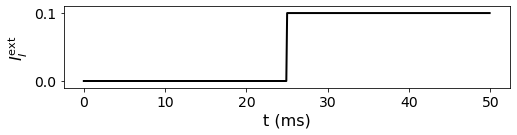

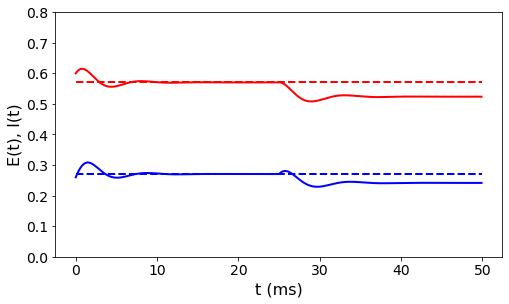

In [30]:
#@title ISN Explorer
pars = default_pars(T=50., dt=0.1)
pars['wEE'], pars['wEI'] = 6.4, 4.8
pars['wIE'], pars['wII'] = 6.0, 1.2
pars['I_ext_E'] = 0.8
pars['tau_I'] = 0.8

def ISN_I_perturb(dI=0.1):
  Lt = len(pars['range_t'])
  pars['I_ext_I'] = np.zeros(Lt)
  pars['I_ext_I'][int(Lt/2):] = dI

  pars['E_init'], pars['I_init'] = 0.6, 0.26
  E,I = simulate_wc(pars)

  plt.figure(figsize=(8, 1.5))

  plt.plot(pars['range_t'], pars['I_ext_I'], 'k')
  plt.xlabel('t (ms)')
  plt.ylabel(r'$I_I^{\mathrm{ext}}$')
  plt.ylim(pars['I_ext_I'].min()-0.01, pars['I_ext_I'].max()+0.01)
  plt.show()

  plt.figure(figsize=(8, 4.5))   
  plt.plot(pars['range_t'], E, 'r')
  plt.plot(pars['range_t'], E[int(Lt/2)-1]*np.ones(Lt), 'r--')
  plt.plot(pars['range_t'], I, 'b')
  plt.plot(pars['range_t'], I[int(Lt/2)-1]*np.ones(Lt), 'b--')
  plt.ylim(0, 0.8)
  plt.xlabel('t (ms)')
  plt.ylabel('E(t), I(t)')
  plt.show()

_ = widgets.interact(ISN_I_perturb, dI = (-0.2, 0.21, .05))

## Bonus 3: Fixed point and working memory

The input into the neurons measured in the experiment is often very noisy ([links](http://www.scholarpedia.org/article/Stochastic_dynamical_systems)) . Here, the noisy synaptic input current is modeled as an Ornstein-Uhlenbeck (OU)process, which has been discussed several times in the previous tutorials.

please execute the following cell of function `my_OU(pars, sig, myseed=False)`

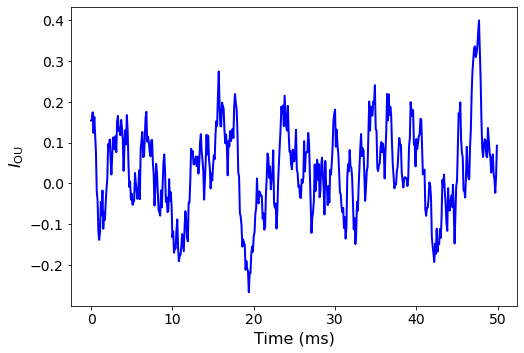

In [31]:
#@title `my_OU(pars, sig, myseed=False)`
def my_OU(pars, sig, myseed=False):
  '''
  Expects:
  pars       : parameter dictionary
  sig        : noise amplitute
  myseed     : random seed. int or boolean
  
  Returns:
  I          : Ornstein-Uhlenbeck input current
  '''
  
  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size
  tau_ou = pars['tau_ou'] # [ms]
  
  # set random seed
  if myseed:
      np.random.seed(seed=myseed) 
  else:
      np.random.seed()
      
  # Initialize
  noise =  np.random.randn(Lt)
  I = np.zeros(Lt)
  I[0] = noise[0] * sig
  
  #generate OU
  for it in range(Lt-1):
      I[it+1] = I[it] + dt/tau_ou*(0.-I[it]) + np.sqrt(2.*dt/tau_ou) * sig * noise[it+1]
  
  return I

pars = default_pars(T=50)
pars['tau_ou'] = 1. #[ms]
sig_ou = 0.1
I_ou = my_OU(pars, sig=sig_ou, myseed=1998)
plt.figure(figsize=(8, 5.5))
plt.plot(pars['range_t'], I_ou, 'b')
plt.xlabel('Time (ms)')
plt.ylabel(r'$I_{\mathrm{OU}}$')
plt.show()

With the default parameters, the system fluctuates around a resting state with the noisy input.


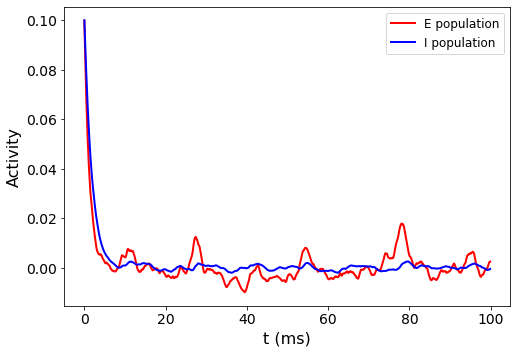

In [32]:
#@title WC with OU
pars = default_pars(T=100)
pars['tau_ou'] = 1. #[ms]
sig_ou = 0.1
pars['I_ext_E'] = my_OU(pars, sig=sig_ou, myseed=20201)
pars['I_ext_I'] = my_OU(pars, sig=sig_ou, myseed=20202)

pars['E_init'], pars['I_init'] = 0.1, 0.1
E,I = simulate_wc(pars)

plt.figure(figsize=(8, 5.5))
ax = plt.subplot(111)
ax.plot(pars['range_t'], E, 'r', label='E population')
ax.plot(pars['range_t'], I, 'b', label='I population')
ax.set_xlabel('t (ms)')
ax.set_ylabel('Activity')
ax.legend(loc='best')
plt.show()


### Short pulse induced persistent activity
Then, let's use a brief 10-ms positive current to the E population when the system is at its equilibrium. When this amplitude is sufficiently large, a persistent activity is produced that outlasts the transient input. What is the firing rate of the persistent activity, and what is the critical input strength? Try to understand the phenomena from the above phase-plane analysis.

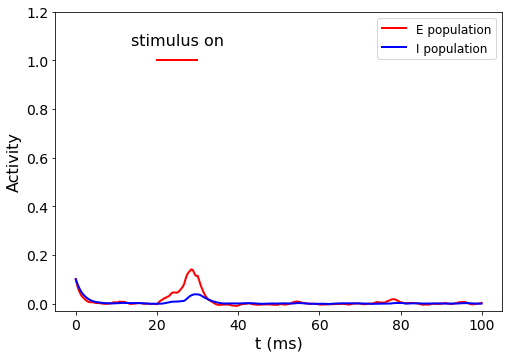

In [33]:
#@title Pulse Explorer

def my_inject(pars, t_start, t_lag=10.):
  '''
  Expects:
  pars       : parameter dictionary
  t_start    : pulse starts [ms]
  t_lag      : pulse lasts  [ms]
  
  Returns:
  I          : extra pulse time
  '''
  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # Initialize
  I = np.zeros(Lt)

  #pulse timing
  N_start = int(t_start/dt)
  N_lag = int(t_lag/dt)
  I[N_start:N_start+N_lag] = 1.

  return I

pars = default_pars(T=100)
pars['tau_ou'] = 1. #[ms]
sig_ou = 0.1
pars['I_ext_I'] = my_OU(pars, sig=sig_ou, myseed=20202)
pars['E_init'], pars['I_init'] = 0.1, 0.1

#pulse
I_pulse = my_inject(pars, t_start=20., t_lag=10.)
L_pulse = sum(I_pulse>0.)

def WC_with_pulse(SE=0.):
  pars['I_ext_E'] = my_OU(pars, sig=sig_ou, myseed=20201)
  pars['I_ext_E'] += SE*I_pulse

  E,I = simulate_wc(pars)

  plt.figure(figsize=(8, 5.5))
  ax = plt.subplot(111)
  ax.plot(pars['range_t'], E, 'r', label='E population')
  ax.plot(pars['range_t'], I, 'b', label='I population')
  
  ax.plot(pars['range_t'][I_pulse>0.], 1.0*np.ones(L_pulse), 'r', lw=2.)
  ax.text(25, 1.05, 'stimulus on', horizontalalignment='center', 
          verticalalignment='bottom')
  ax.set_ylim(-0.03, 1.2)
  ax.set_xlabel('t (ms)')
  ax.set_ylabel('Activity')
  ax.legend(loc='best')
  plt.show()

_ = widgets.interact(WC_with_pulse, SE = (0.45, 0.5, .01))

Explore what happened when a second, brief current is applied onto the inhibitory population. 